In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import keras
from keras.models import *
from keras.layers import *
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
from keras import backend as K
K.set_session(session)

C:\Users\peter\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
DATASET_ROOT = './0601'
TRAIN_PATH = os.path.join(DATASET_ROOT, 'taetfp.csv')
AUX_PATH = os.path.join(DATASET_ROOT, 'tasharep.csv')
TS_IN=20
TS_OUT=5
fields = ['開盤價(元)', '最高價(元)', '最低價(元)', '收盤價(元)', '成交張數(張)']
fields_dict = dict()
for n, f in enumerate(fields):
    fields_dict[f] = n

In [3]:
train_csv = pd.read_csv(TRAIN_PATH)
train_csv.sort_values(by=['日期', '代碼'], ascending=True, inplace=True)
train_csv[fields] = train_csv[fields].applymap(lambda x: float(x.replace(',','')) if type(x)==str else x)
display(train_csv.head(n=10))

aux_csv = pd.read_csv(AUX_PATH)
aux_csv.sort_values(by=['日期', '代碼'], ascending=True, inplace=True) # 照 '日期' 和 '代碼' 排序 (重要)
aux_csv[fields] = aux_csv[fields].applymap(lambda x: float(x.replace(',','')) if type(x)==str else x)
display(aux_csv.head(n=10))

,代碼,日期,中文簡稱,開盤價(元),最高價(元),最低價(元),收盤價(元),成交張數(張)
0,50,20130102,元大台灣50,46.57,47.13,46.49,46.92,16487.0
1327,51,20130102,元大中型100,22.36,22.66,22.36,22.65,277.0
2654,52,20130102,富邦科技,26.57,26.95,26.57,26.92,26.0
3981,53,20130102,元大電子,19.84,19.84,19.52,19.81,42.0
5308,54,20130102,元大台商50,16.84,16.84,16.54,16.75,20.0
6635,55,20130102,元大MSCI金融,9.85,9.94,9.83,9.91,2210.0
7962,56,20130102,元大高股息,18.45,18.63,18.45,18.55,1623.0
9289,57,20130102,富邦摩台,30.35,30.69,30.35,30.69,69.0
10616,58,20130102,富邦發達,32.45,32.45,32.12,32.12,2.0
11943,59,20130102,富邦金融,24.65,24.65,24.65,24.65,2.0


C:\Users\peter\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (3,4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,代碼,日期,中文簡稱,開盤價(元),最高價(元),最低價(元),收盤價(元),成交張數(張)
0,1101,20130102,台泥,30.41,30.53,30.18,30.45,6374.0
1327,1102,20130102,亞泥,28.74,28.90,28.70,28.78,2856.0
2654,1103,20130102,嘉泥,12.29,12.33,12.24,12.24,315.0
3981,1104,20130102,環泥,11.87,12.17,11.87,12.06,551.0
5308,1108,20130102,幸福,5.18,5.22,5.16,5.18,447.0
6635,1109,20130102,信大,9.24,9.28,9.19,9.24,104.0
7962,1110,20130102,東泥,13.41,13.46,13.23,13.23,169.0
9289,1201,20130102,味全,35.69,37.74,35.44,37.69,8971.0
10616,1203,20130102,味王,16.61,16.78,16.61,16.73,143.0
11943,1210,20130102,大成,16.84,16.99,16.84,16.87,1373.0


In [4]:
codes = list(sorted(set(train_csv['代碼'])))
aux_codes = np.load('codes_subset.npy') # sorted
days  = list(sorted(set(train_csv['日期']))) # 在 taetfp 內出現的日期才被我們使用
#days_dict = dict()
#for n, day in enumerate(days):
#    days_dict[day] = n

In [5]:
aux_csv = aux_csv.loc[aux_csv['代碼'].isin(aux_codes) & aux_csv['日期'].isin(days)] # 只找在 subset 內的資料

In [6]:
split_days = [] # 同一天分一堆
for day in days:
    row = aux_csv.loc[aux_csv['日期']==day][fields]
    split_days.append(np.asarray(row, dtype=np.float32))
split_days = np.asarray(split_days, dtype=np.float32)

In [7]:
print(split_days.shape) # 先當作日期有對齊好 shape: (1317, 1388, 5) -> 1317 天, 每天有 1388 支股票, 每支股票有 5 個 feature

(1327, 1388, 5)


In [8]:
split_days = split_days.reshape(split_days.shape[0], -1) # shape: (1317, 1388*5=6940) , 攤平
print(split_days.shape)

(1327, 6940)


In [9]:
# Load fitted PCA 
pca_mean = np.load('pca_mean.npy')
pca_components = np.load('pca_components.npy')
print(pca_mean.shape)
print(pca_components.shape)

(6940,)
(122, 6940)


In [10]:
def pca_apply(data_): # data shape: (?, 6940)
    data = data_.transpose((1,0)) # (6940, ?)
    centered_data = data - pca_mean[...,np.newaxis]
    return np.transpose(np.matmul(pca_components, centered_data) ,(1,0)) # (34, 6940) * (6940, ?) = (34, ?) -> (?, 34)

In [11]:
# 套用 PCA (substract mean, pca transform)
split_days_reduced = pca_apply(split_days)
print(split_days_reduced.shape) # (1317, 34)

(1327, 122)


In [12]:
split_train = []
for code in codes:
    row   = np.asarray(train_csv.loc[train_csv['代碼']==code][fields], dtype=np.float32)
    aux_pca_data = split_days_reduced[-row.shape[0]:,:] # 對齊最後幾天 (先當作這樣就對齊了)
    label = np.append(np.array([0], dtype=np.float32), (row[1:,-2] > row[:-1,-2]).astype(np.float32)).astype(np.float32)[...,np.newaxis]
    #row[day-0:, 收盤價] > row[:day-n, 收盤價]
    row = np.concatenate([row, aux_pca_data, label], axis=-1)
    split_train.append(row)

In [13]:
for n, s in enumerate(split_train):
    print(codes[n], s.shape)

50 (1327, 128)
51 (1327, 128)
52 (1327, 128)
53 (1327, 128)
54 (1327, 128)
55 (1327, 128)
56 (1327, 128)
57 (1327, 128)
58 (1327, 128)
59 (1327, 128)
690 (289, 128)
692 (259, 128)
701 (194, 128)
713 (165, 128)
6201 (1327, 128)
6203 (1327, 128)
6204 (1327, 128)
6208 (1327, 128)


In [14]:
from keras.regularizers import *

# custom R2-score metrics for keras backend
def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) # mse, model interpretable error
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) # y_true likelyhood variance, not interpretable error
    return (1 - SS_res/(SS_tot + K.epsilon()))
    # if SS_res == SS_tot: at least the model can fit to some extent
    # if SS_res >> SS_tot: the model is lame

def classification_score(y_true, y_pred):
    weights = K.constant([0.1, 0.15, 0.2, 0.25, 0.3], dtype='float32', shape=(1,5,1))
    eq = K.cast(K.equal(K.round(y_true), K.round(y_pred)), 'float32') # shape: batch size, 5, 1 
    return K.mean(K.sum(eq * weights, axis=-2)) # dot_product(eq(batch size, 5, 1), weights(1,5,1)) -> K.mean((batch size, 1)) -> score

def regress_loss(y_true, y_pred):
    weights = K.constant([0.1, 0.15, 0.2, 0.25, 0.3], dtype='float32', shape=(1,5,1))
    wmse = K.mean(K.sum(K.square(y_true-y_pred) * weights, axis=-2)) # mean squared error with weights
    return wmse

def classification_loss(y_true, y_pred):
    weights = K.constant([0.1, 0.15, 0.2, 0.25, 0.3], dtype='float32', shape=(1,5,1))
    wbce = K.mean(K.sum(K.binary_crossentropy(y_true, y_pred) * weights, axis=-2))
    return wbce

def regression_score(y_true, y_pred):
    weights = K.constant([0.1, 0.15, 0.2, 0.25, 0.3], dtype='float32', shape=(1,5,1))
    return K.mean(K.sum((y_true - K.abs(y_pred-y_true)) / (y_true+K.epsilon()) * weights, axis=-2))

def make_model(ts_in=60, ts_out=5, n_field=128, n_encode=256, n_decode=128, reg_a=0.1):
    input_ = Input(shape=(ts_in, n_field))
    noise = GaussianNoise(1e-6) (input_)
    lstm_1 = Bidirectional(CuDNNLSTM(n_encode, return_sequences=True, recurrent_regularizer=l2(reg_a)), merge_mode='sum') (noise)
    lstm_2 = Bidirectional(CuDNNLSTM(n_encode, return_sequences=False, recurrent_regularizer=l2(reg_a)), merge_mode='sum') (lstm_1)
    rep_vec_2 = RepeatVector(ts_out) (lstm_2)
    lstm_3 = CuDNNLSTM(n_decode, return_sequences=True, recurrent_regularizer=l2(reg_a)) (rep_vec_2)
    lstm_4 = CuDNNLSTM(n_decode, return_sequences=True, recurrent_regularizer=l2(reg_a)) (lstm_3)
    fc_4_regression     = TimeDistributed(Dense(1, kernel_regularizer=l2(reg_a)), name='regression') (lstm_4)
    fc_4_classification = TimeDistributed(Dense(1, kernel_regularizer=l2(reg_a), activation='sigmoid'), name='class') (lstm_4)
    return Model([input_], [fc_4_regression, fc_4_classification])
make_model(ts_in=TS_IN, ts_out=TS_OUT).summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 20, 128)      0                                            
__________________________________________________________________________________________________
gaussian_noise_1 (GaussianNoise (None, 20, 128)      0           input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 20, 256)      790528      gaussian_noise_1[0][0]           
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 256)          1052672     bidirectional_1[0][0]            
__________________________________________________________________________________________________
repeat_vec

In [15]:
def make_seq(seq, ts_in=60, ts_out=5):
    Xs = []
    Ys = []
    Ys_label = []
    total_l = ts_in + ts_out
    for i in range(0, len(seq)-total_l+1):
        Xs.append(seq[i:i+ts_in])
        Ys.append(seq[i+ts_in:i+total_l, 3:4])
        Ys_label.append(seq[i+ts_in:i+total_l, -1:]) # 漲跌
    return np.asarray(Xs), np.asarray(Ys), np.asarray(Ys_label)

In [16]:
train_18 = []
for seq in split_train:
    Xs, Ys, Ys_label = make_seq(seq, ts_in=TS_IN, ts_out=TS_OUT)
    train_18.append([Xs, Ys, Ys_label])

In [17]:
from matplotlib.figure import figaspect
def vis(history, title='no title', dpi=80):
    # r2, classification_score, regression_score, lb
    fig_, ax_ = plt.subplots(2, 3, dpi=80, figsize=(20, 5))
    ax = ax_.ravel()
    titles = ['wmse', 'wbce', 'r2', 'classification_score', 'regression_score', 'lb']
    for i, p in enumerate(titles):
        ax[i].set_title(title + ' ' + p + ' plot')
    for i in range(6):
        ax[i].set_xlabel('epoch')
    scores = ['wmse', 'wbce', 'r2', 'acc', 't_brain_regression', 'lb']
    for i, s in enumerate(scores):
        ax[i].set_ylabel(s)
    metric_names = ['regression_loss', 'class_loss', 'regression_r2_keras', 'class_classification_score', 'regression_regression_score']
    locs = [0, 0, 1, 1, 1]
    for i, (name, loc) in enumerate(zip(metric_names, locs)):
        ax[i].plot(history.history[name])
        ax[i].plot(history.history['val_'+name])
        ax[i].legend(['train','valid'], loc='upper right' if loc==0 else 'lower right')
    ax[-1].plot(0.5 * np.asarray(history.history['class_classification_score']) + 0.5 * np.asarray(history.history['regression_regression_score']))
    ax[-1].plot(0.5 * np.asarray(history.history['val_class_classification_score']) + 0.5 * np.asarray(history.history['val_regression_regression_score']))
    ax[-1].legend(['train','valid'], loc='upper right' if loc==0 else 'lower right')
    plt.tight_layout()
    plt.show()

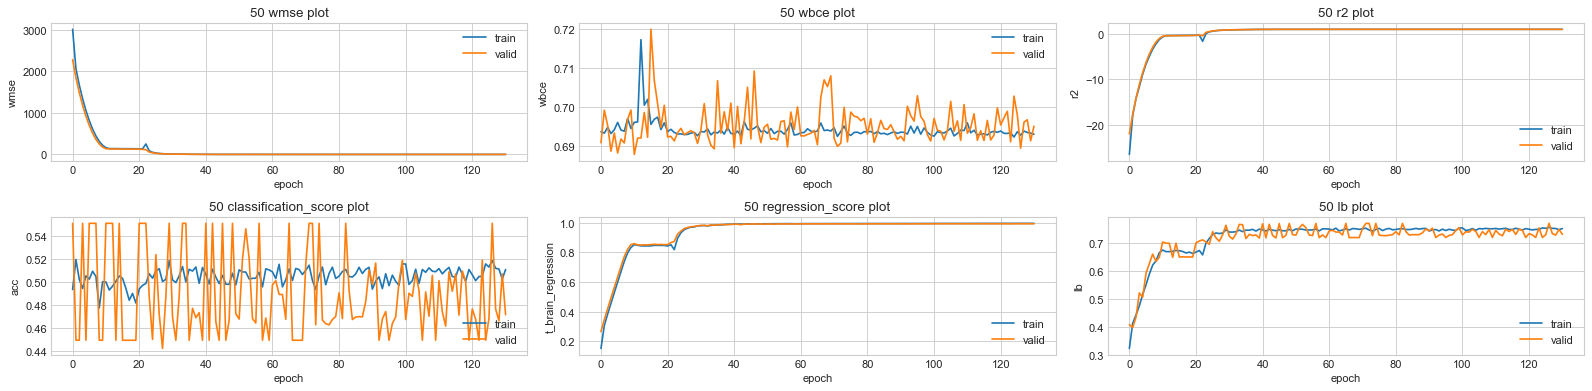

validation wbce: 0.691420
validation wmse: 0.815745
validation r2 : 0.987824
validation acc: 0.506897
validation regression: 0.992558
validation lb: 0.749727


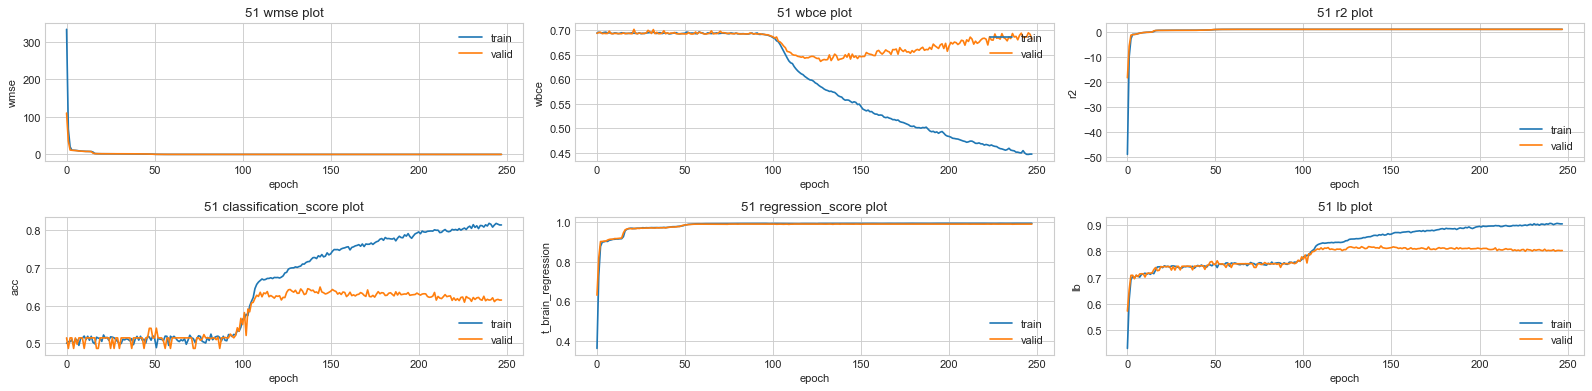

validation wbce: 0.681864
validation wmse: 0.146460
validation r2 : 0.969571
validation acc: 0.614559
validation regression: 0.991555
validation lb: 0.803057


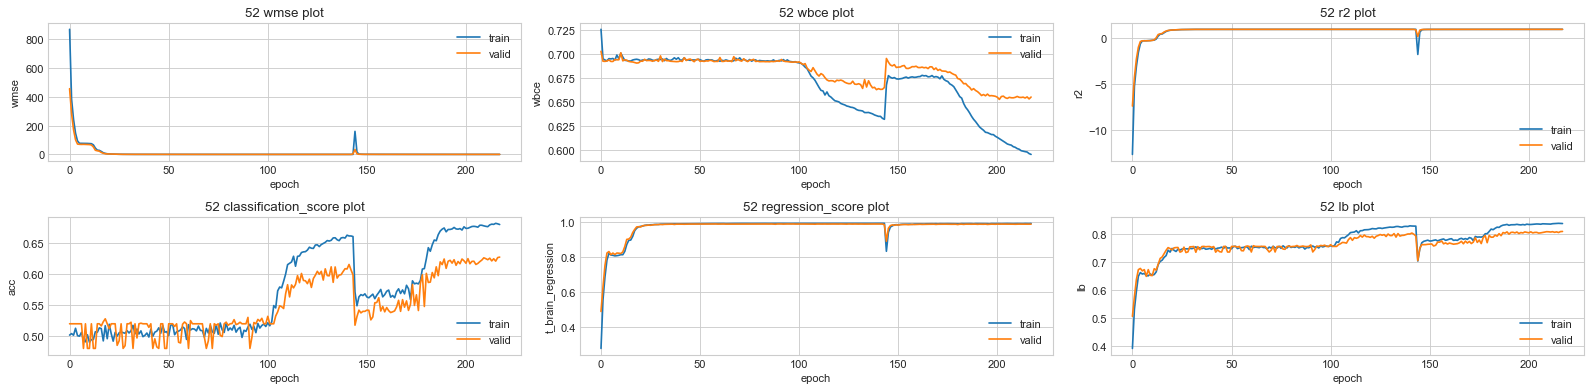

validation wbce: 0.655163
validation wmse: 0.478266
validation r2 : 0.987868
validation acc: 0.621648
validation regression: 0.989338
validation lb: 0.805493


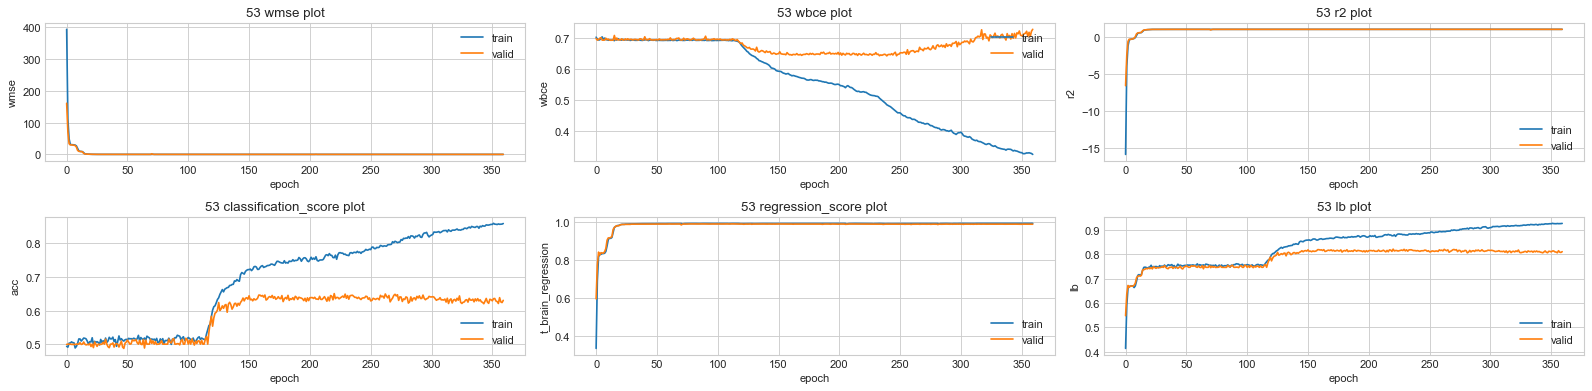

validation wbce: 0.705216
validation wmse: 0.168189
validation r2 : 0.990544
validation acc: 0.625671
validation regression: 0.991079
validation lb: 0.808375


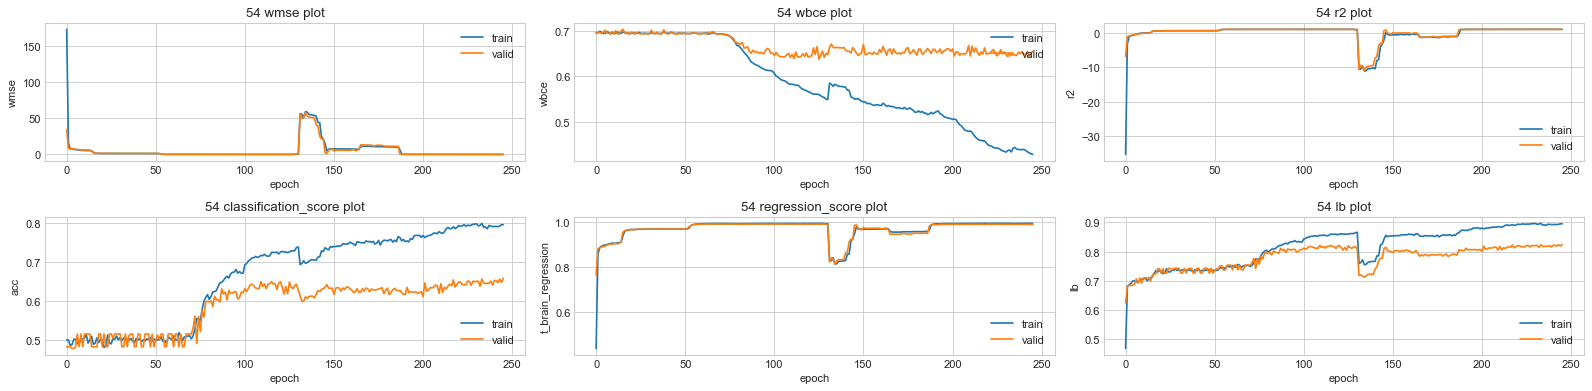

validation wbce: 0.644182
validation wmse: 0.123919
validation r2 : 0.966285
validation acc: 0.646360
validation regression: 0.990434
validation lb: 0.818397


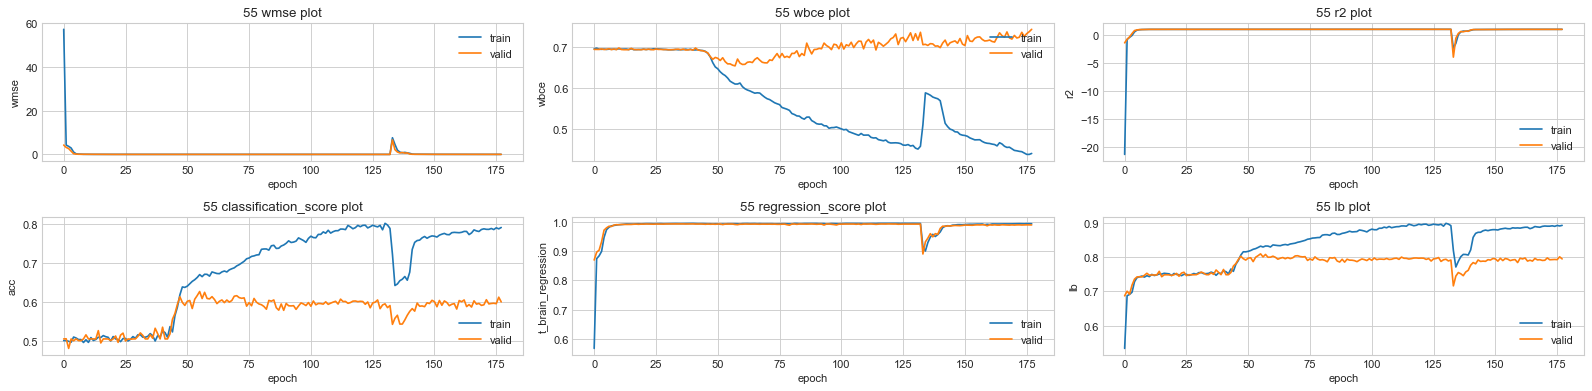

validation wbce: 0.655166
validation wmse: 0.030199
validation r2 : 0.982306
validation acc: 0.608812
validation regression: 0.991730
validation lb: 0.800271


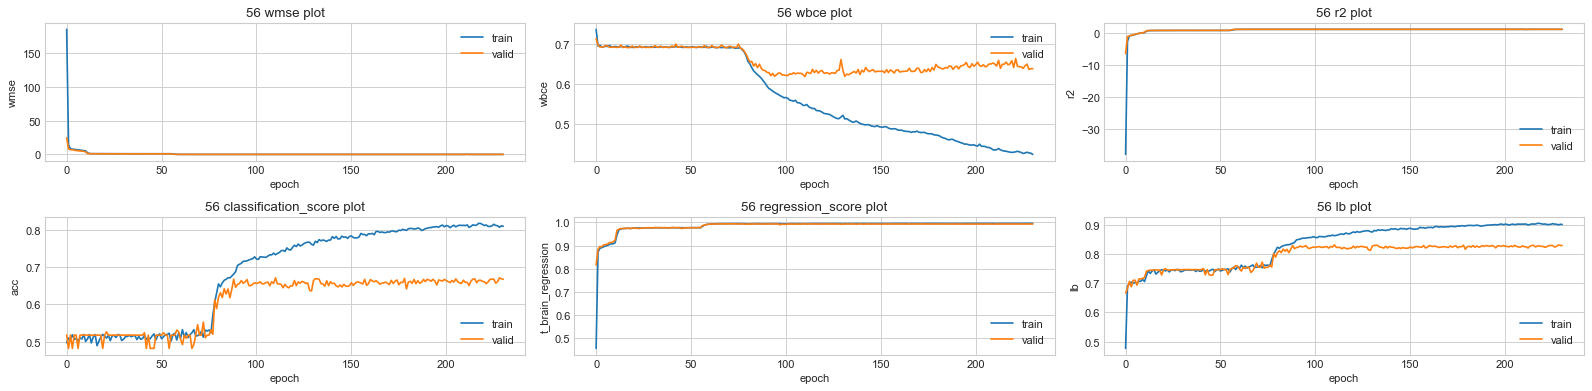

validation wbce: 0.636821
validation wmse: 0.058511
validation r2 : 0.982138
validation acc: 0.671264
validation regression: 0.992646
validation lb: 0.831955


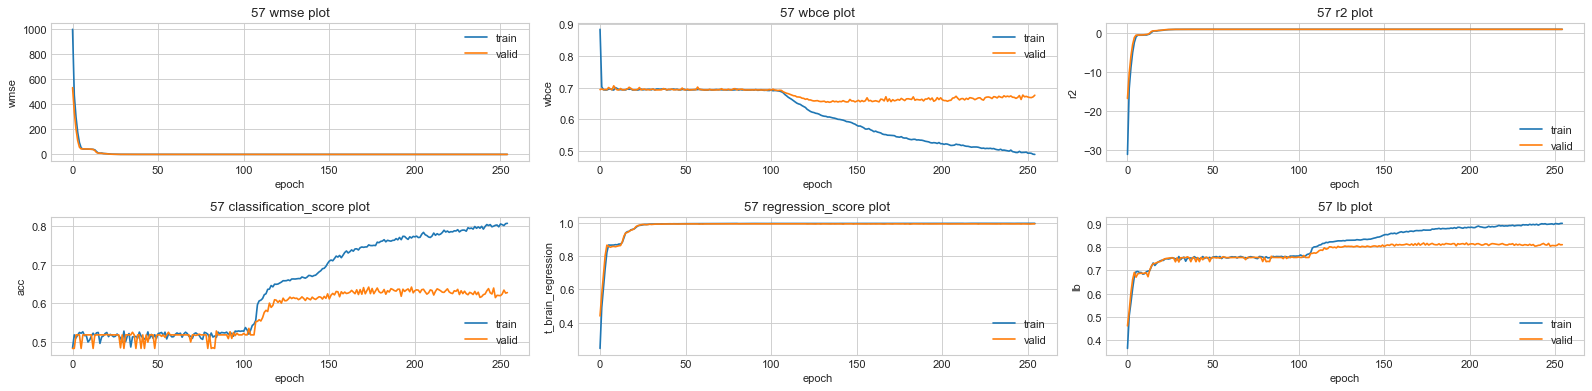

validation wbce: 0.670524
validation wmse: 0.273487
validation r2 : 0.987374
validation acc: 0.626437
validation regression: 0.992458
validation lb: 0.809447


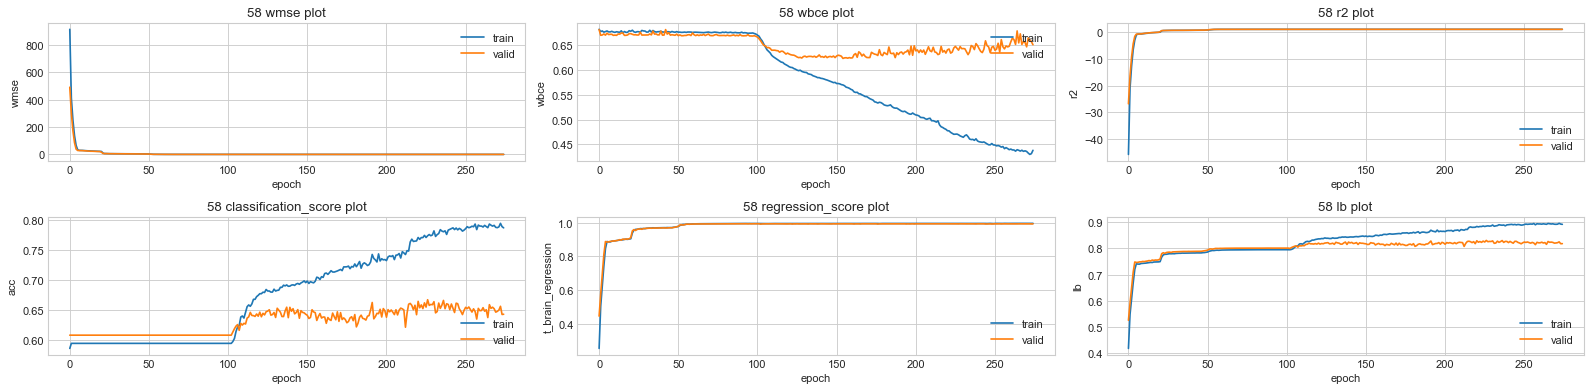

validation wbce: 0.646487
validation wmse: 0.225385
validation r2 : 0.983311
validation acc: 0.647893
validation regression: 0.992770
validation lb: 0.820332


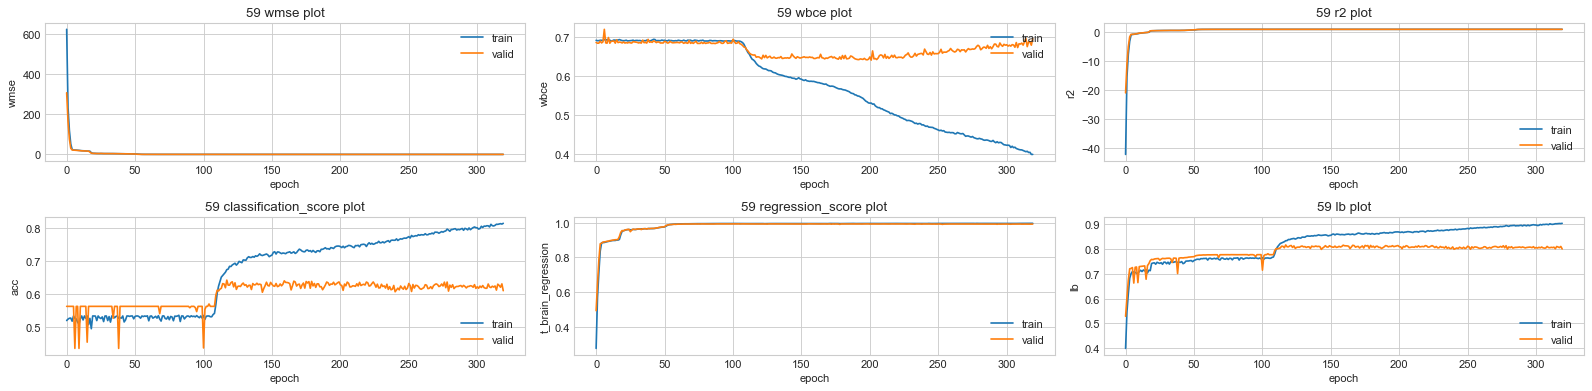

validation wbce: 0.676353
validation wmse: 0.248714
validation r2 : 0.975985
validation acc: 0.630268
validation regression: 0.991281
validation lb: 0.810775


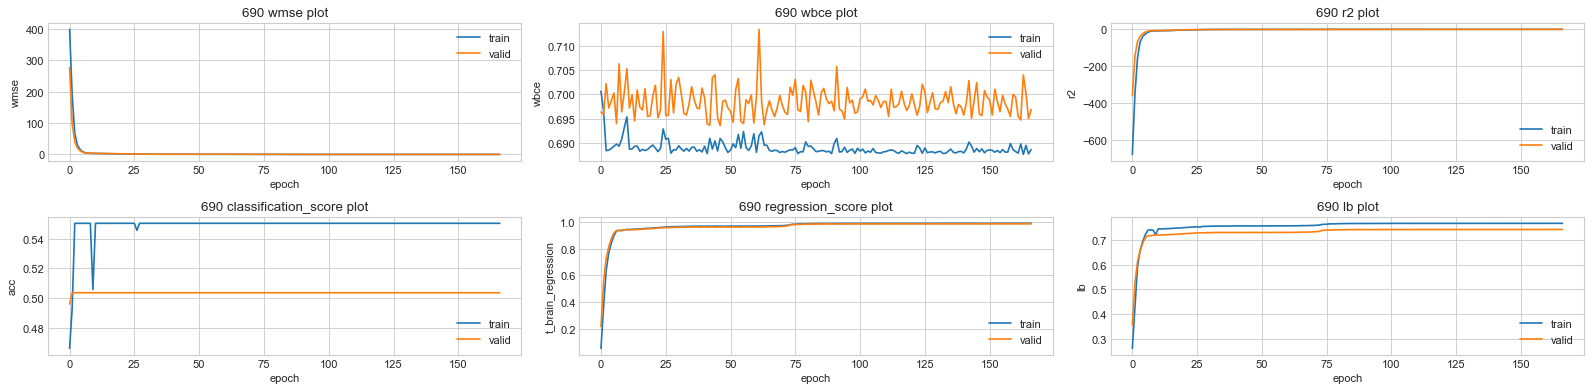

validation wbce: 0.694989
validation wmse: 0.268653
validation r2 : 0.445935
validation acc: 0.503774
validation regression: 0.985555
validation lb: 0.744664


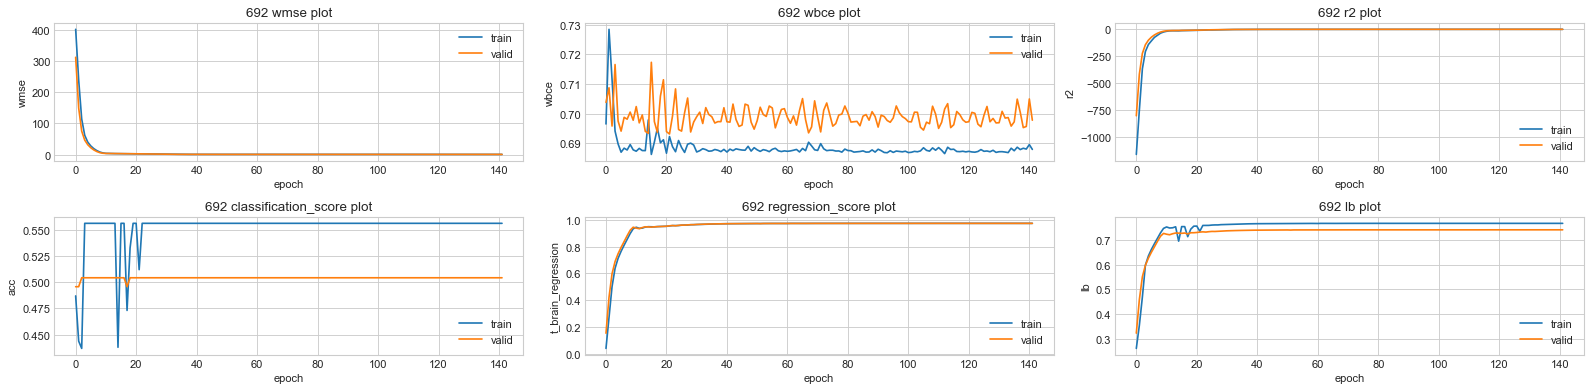

validation wbce: 0.695677
validation wmse: 0.422184
validation r2 : -0.069089
validation acc: 0.504255
validation regression: 0.974737
validation lb: 0.739496


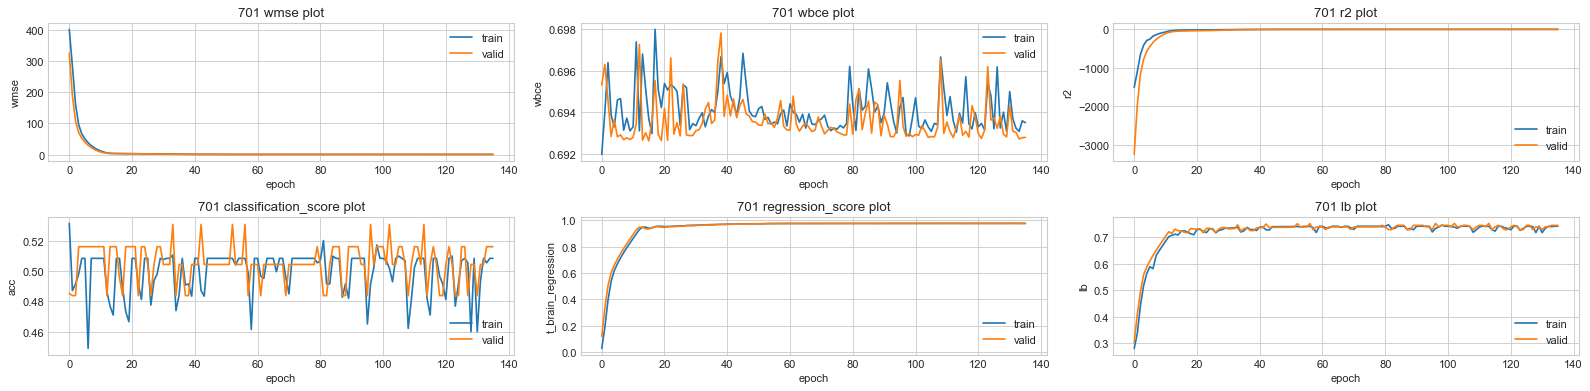

validation wbce: 0.693107
validation wmse: 0.303380
validation r2 : -1.808253
validation acc: 0.504412
validation regression: 0.975668
validation lb: 0.740040


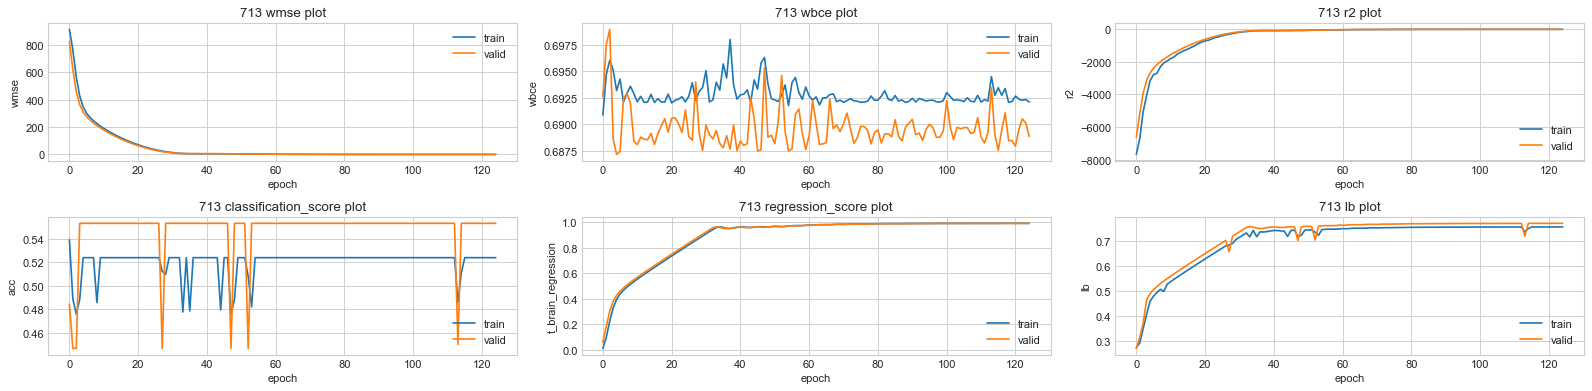

validation wbce: 0.688842
validation wmse: 0.188031
validation r2 : -0.961720
validation acc: 0.553448
validation regression: 0.988516
validation lb: 0.770982


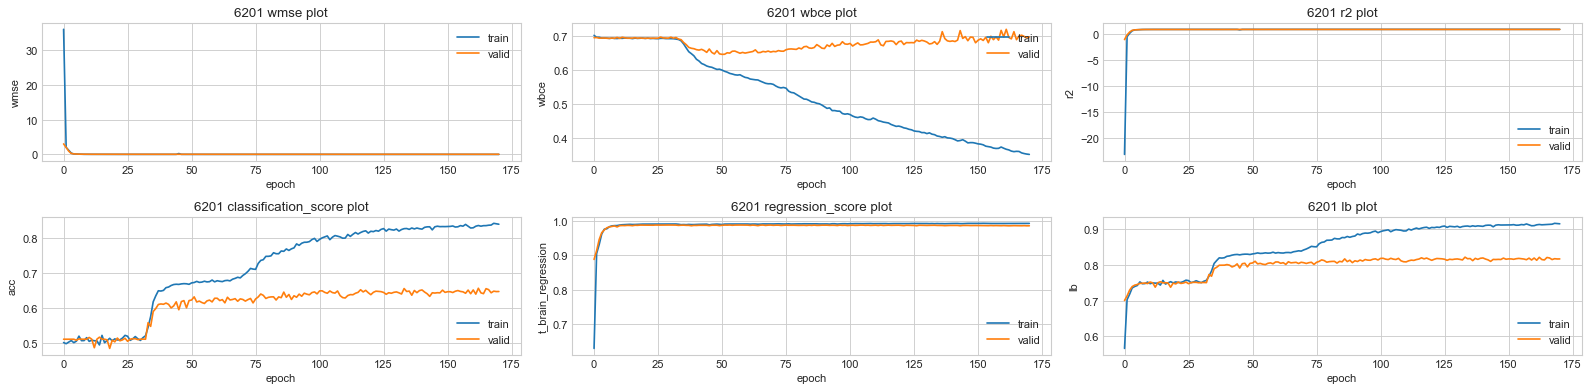

validation wbce: 0.646023
validation wmse: 0.061084
validation r2 : 0.951439
validation acc: 0.632184
validation regression: 0.988737
validation lb: 0.810460


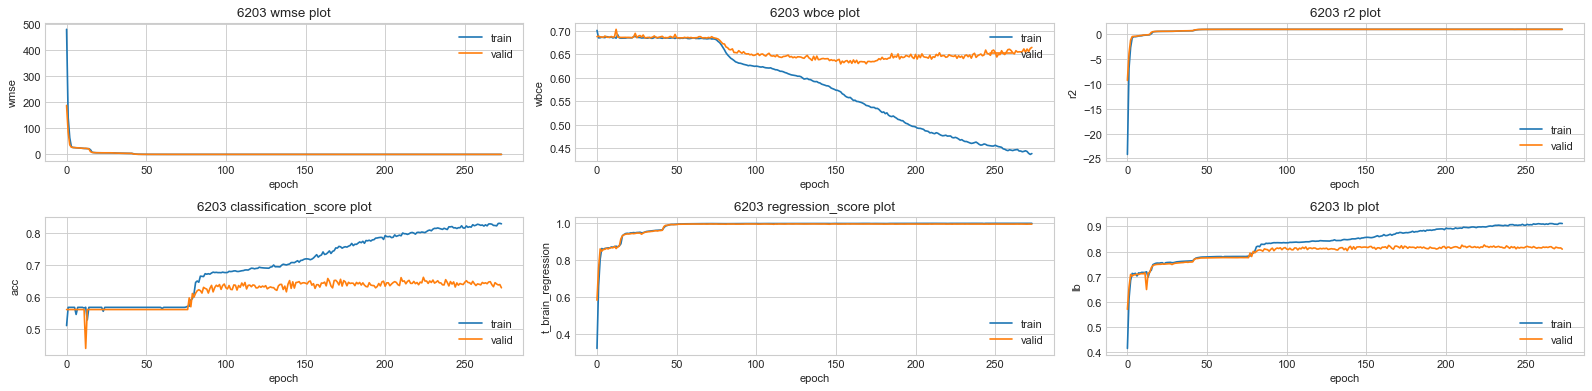

validation wbce: 0.655831
validation wmse: 0.170684
validation r2 : 0.987748
validation acc: 0.637165
validation regression: 0.991591
validation lb: 0.814378


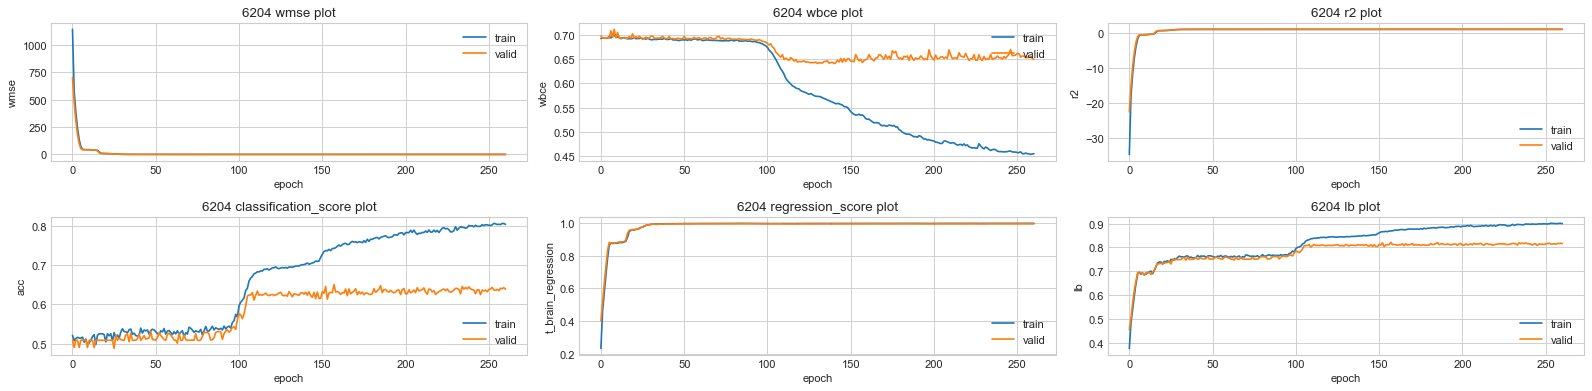

validation wbce: 0.649020
validation wmse: 0.317967
validation r2 : 0.984768
validation acc: 0.638697
validation regression: 0.992814
validation lb: 0.815756


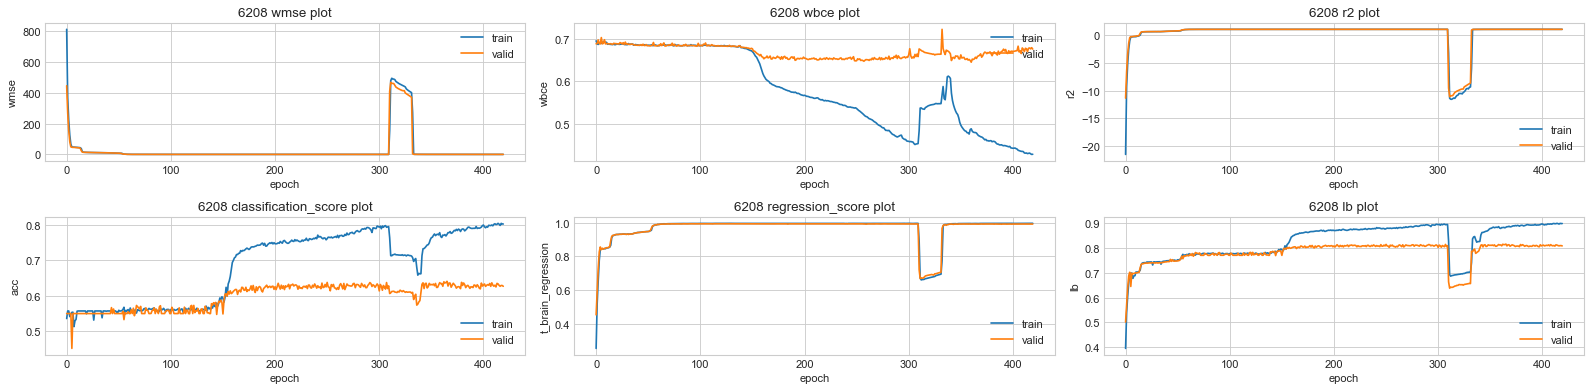

validation wbce: 0.665568
validation wmse: 0.288153
validation r2 : 0.988630
validation acc: 0.636590
validation regression: 0.991182
validation lb: 0.813886


In [18]:
from keras.callbacks import *
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
BATCH_SIZE = 32 # batch size 不要太大, 我們仍然會希望去學習多一點資料中的變異
EPOCH = 900
total_lb = 0
total_vlb = 0
for model_n, (X, Y, label) in enumerate(train_18):
    prefix = str(codes[model_n])
    
    X_train, X_test, Y_train, Y_test, label_train, label_test = train_test_split(X, Y, label, test_size=0.2)
    
    earlystop_class = EarlyStopping(monitor='val_class_loss', patience=120)
    earlystop_reg   = EarlyStopping(monitor='val_regression_loss', patience=120)
    ckpt = ModelCheckpoint(prefix+'_model.h5', save_best_only=True)
    
    model = make_model(ts_in=TS_IN, ts_out=TS_OUT)
    model.compile(loss={'regression':regress_loss, 'class':classification_loss}, optimizer=Adam(clipnorm=1.0), metrics = {'regression':[r2_keras, regression_score], 'class':[classification_score]}, loss_weights={'class':2, 'regression':1})
    history = model.fit(X_train, [Y_train, label_train], validation_data=(X_test, [Y_test, label_test]) , batch_size=BATCH_SIZE, epochs=EPOCH, callbacks=[TensorBoard(log_dir=prefix+'_logs'), earlystop_class, earlystop_reg, ckpt], shuffle=True, verbose=0)
    
    vis(history, title=prefix, dpi=180)
    
    best_e = np.argmin(history.history['val_loss'])
    
    vlb = 0.5*history.history['val_regression_regression_score'][best_e]+0.5*history.history['val_class_classification_score'][best_e]
    print('validation wbce: {:.6f}'.format(history.history['val_class_loss'][best_e]))
    print('validation wmse: {:.6f}'.format(history.history['val_regression_loss'][best_e]))
    print('validation r2 : {:.6f}'.format(history.history['val_regression_r2_keras'][best_e]))
    print('validation acc: {:.6f}'.format(history.history['val_class_classification_score'][best_e]))
    print('validation regression: {:.6f}'.format(history.history['val_regression_regression_score'][best_e]))
    print('validation lb: {:.6f}'.format(vlb))
    
    total_lb += 0.5*history.history['regression_regression_score'][best_e]+0.5*history.history['class_classification_score'][best_e]
    total_vlb += vlb
    
    K.clear_session()

In [19]:
print('Overall training lb: {:.6f}'.format(total_lb))
print('Overall validation lb: {:.6f}'.format(total_vlb))

Overall training lb: 15.287216
Overall validation lb: 14.307491


![](https://tbrain.trendmicro.com.tw/Content/img/18etf.png)

#### Todo:
1. Check missing data / value
2. Do more EDA on dataset
3. Try more baseline models (LSTM, GRU, CNN-1D, XGBoost, SVM, ...) 
4. Add Candlestick chart
5. Add n-fold cross validation
6. 是否天數有對齊?
